In [ ]:
#@title Imports
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-qsmacjih
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-qsmacjih
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 1.0 MB/s eta 0:00:00
  Created wheel for gym-neu-racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=65580 sha256=6829d1297fcb68fedb5a9bc95b6a8a48d014dc689538d260388dc26e07f84ef6
  Stored in directory: /tmp/pip-ephem-wheel-cache-4rfjd0n_/wheels/2b/40/20/13d3d44e20167f192ae2e89c0c279882d6064e6d226cc3efaa
Successfully built gym-neu-racing


In [ ]:
#@title Motion Models

class MotionModel:
    """Abstract class for modeling the motion of a 2D mobile robot."""

    def __init__(self):
        pass

    def step(self, current_state, action, dt=0.1):
        """Move 1 timestep forward w/ kinematic model, x_{t+1} = f(x_t, u_t)"""
        raise NotImplementedError

class Unicycle(MotionModel):
    def __init__(self, v_min=0, v_max=1, w_min=-2*np.pi, w_max=2*np.pi):
        self.action_space = spaces.Box(np.array([v_min, w_min]),
                                       np.array([v_max, w_max]),
                                       shape=(2,),
                                       dtype=float)
        super().__init__()

    def step(self, current_state: np.ndarray, action: np.ndarray, dt: float = 0.1) -> np.ndarray:
        # current_state = np.array([x, y, theta])
        # action = np.array([vx, vw])
        action[0] = np.clip(action[0], self.action_space.low[0], self.action_space.high[0])
        action[1] = np.clip(action[1], self.action_space.low[1], self.action_space.high[1])

        x, y, theta = current_state

        T = np.array([
            [np.cos(theta), 0],
            [np.sin(theta), 0],
            [0, 1]
        ])

        d_state = T @ action
        next_state = current_state + dt * d_state

        return next_state

class NoisyUnicycle(Unicycle):
  """Same as Unicycle but add process noise at each step."""
  def __init__(self,
               process_noise_limits=np.array([0.1, 0.1, 0.5]),
               v_min=0, v_max=1, w_min=-2*np.pi, w_max=2*np.pi):
    self.process_noise_limits = process_noise_limits
    super().__init__(v_min=v_min, v_max=v_max, w_min=w_min, w_max=w_max)

  def step(self, current_state, action, dt=0.1) -> np.ndarray:

    """Add process noise to the parent kinematics model."""
    next_state = super().step(current_state, action, dt=dt)
    perturbed_next_state = next_state + np.random.uniform(low=-self.process_noise_limits, high=self.process_noise_limits)

    return perturbed_next_state

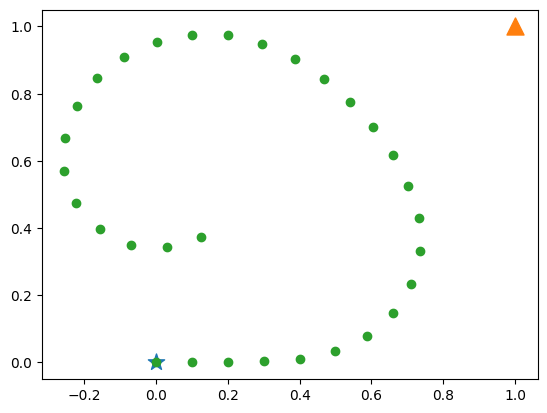

In [ ]:
#@title MPPI
class MPPIRacetrack:
    def __init__(
        self,
        # static_map,
        motion_model=Unicycle(),
        sigma = 3,
        lmbd = 10,
        num_samples = 70,
        timesteps = 10,

    ):
        """ Your implementation here """
        # self.static_map = static_map
        self.motion_model = motion_model
        self.sigma = sigma
        self.lmbd = lmbd
        self.num_samples = num_samples
        self.timesteps = timesteps
        self.u = np.zeros((self.timesteps, 2))
        self.count = 0


    def clip(self, velocity, angular):
      velocity = np.clip(velocity, self.motion_model.action_space.low[0], self.motion_model.action_space.high[0])
      angular = np.clip(angular, self.motion_model.action_space.low[1], self.motion_model.action_space.high[1])

      return np.array([velocity, angular])

    def cost(self, current_state, next_state, cur_action):
      return np.sum((next_state[:2] - np.array([1, 1]))**2)
      # coord, in_map = self.static_map.world_coordinates_to_map_indices(next_state[:2])
      # if self.static_map.static_map[coord[0], coord[1]]:
      #   return 100

      # # current_state = current_state - 0.6
      # d = np.abs( ( (next_state[0] - 0.6) / 3.3)**2 + ( (next_state[1] - 0.7) / 3.3)**2 - 1 )
      # cost = 60 * d**2 + (cur_action[0] - 2)**2

      # return cost

    def plot(self, initial_state, goal_pos, rollout):
      plt.axis('equal')
      rollout = np.array(rollout)
      plt.plot(initial_state[0], initial_state[1], 'o')
      plt.plot(goal_pos[0], goal_pos[1], 'x')
      plt.plot(rollout[:, 0], rollout[:, 1])

      # plt.show()

    def get_action(self, initial_state: np.ndarray):
      """ Your implementation here """
      #set nominal control for unicycle, vx, vw
      self.count += 1
      u = self.u.copy()

      #sample perturbations from normal dist
      perturbations = np.random.normal(0, self.sigma, size = (self.num_samples, self.timesteps, 2))

      weights = np.zeros((self.num_samples, 1))
      rollouts = []
      #for every sample
      for i, perturbation in enumerate(perturbations):
        cur_state = initial_state
        cur_rollout = [initial_state]
        cost = 0
        #for every time step
        for t in range(self.timesteps):
          cur_action = u[t] + perturbation[t]
          cur_action = self.clip(cur_action[0], cur_action[1])
          next_state = self.motion_model.step(cur_state, cur_action)
          cur_rollout.append(next_state)
          cost += self.cost(cur_state, next_state, cur_action)
          cur_state = next_state

        # self.plot(initial_state, goal_pos, cur_rollout)
        rollouts.append(cur_rollout)
        weights[i] = np.exp(-(1/self.lmbd) * cost)

      weights = weights / np.sum(weights)
      for i in range(self.timesteps):
        u[i] = u[i] + np.sum(weights * perturbations[:, i, :], axis = 0)

      action = u[0]
      action[0] = 1

      self.u = u

      return rollouts, self.u.copy()

mppi = MPPIRacetrack()
motion_model = Unicycle()
cur_state = np.array([0, 0, 0])
xs = [cur_state[:2]]
for i in range(30):
  _, u_list = mppi.get_action(cur_state)
  u = u_list[0]
  next_state = motion_model.step(cur_state, u)
  xs.append(next_state[:2])
  cur_state = next_state

xs = np.array(xs)
plt.scatter(0, 0, s = 150, marker = '*')
plt.scatter(1, 1, s = 150, marker = '^')
plt.scatter(xs[:, 0], xs[:, 1])

In [ ]:
#@title Iterative LQG
class IterativeLQG:
  def __init__(self,
               x0 = np.zeros(3),
               motion_model=motion_models.Unicycle(),
               K = 10,
               T = 1,
               ):
    #time discretization
    self.Q = np.eye(3)
    self.R = np.eye(2)
    self.K = K
    self.T = T
    self.dt = self.T / (self.k - 1)
    self.u = np.zeros((K-1, 2))
    self.motion_model = motion_model
    pass

  def linearize(self):
    pass

  def quad_cost(self):
    pass

  def backward(self):

    pass

  def compute_l(self, x, u):
    l = (1/2) * (x.T @ Q @ x) + (1/2) * (u.T @ Q @ u)
    return l

  def lqr(self, x):
    A_k, B_k = self.compute_system_matrices(x)
    S = np.matrix(scipy.linalg.solve_discrete_are(A_k, B_k, self.Q, self.R))
    K = np.matrix(scipy.linalg.inv(self.R) @ B_k.T @ P)

    return -K, S

  def simulate(self):
    xs = [self.x0]
    for i in range(self.K):
      next_state = self.motion_model.step(xs[i], self.u[i], self.dt)
      xs.append(next_state)

    return np.array(xs)

  def compute_system_matrices(self, x, u):
        """
        Compute system dynamics matrices A and B given state x
        """
        theta = x[2]
        A_k = np.array([
            [0, 0, -u[0] * np.sin(theta)],
            [0, 0, u[0] * np.cos(theta)],
            [0, 0, 0]
        ])

        B_k = np.array([
            [np.cos(theta), 0],
            [np.sin(theta), 0],
            [0, 1]
        ])

        B_k = B_k * self.dt

        return A_k, B_k

  def solve(self):
    #apply u_bar to motion model to get x_bar

    #compute linearized dynamics and quadratized costs
    linearized = self.linearize()
    quad_cost = self.quad_cost()

    #calculate the deviations of the noisy and deterministic models

    #backward pass, computes control law
    control = self.backward()

    #apply control law to deterministic system



IndentationError: expected an indented block after function definition on line 24 (<ipython-input-1-5720f6d41f00>, line 26)

667.3572196306071
643.868152247359
628.6091067551729
618.7286096594887
612.5139396411448
607.7930500816186
602.6566709762932
595.9758108430423
587.2189879755115
556.679579489831
519.8639345713373
465.94261120678993
462.7712040484207
441.8272007401135
431.63189971157954
427.64364806936305
426.0977306109652
424.9657665038973
423.9205978693388
422.83274928142293
421.6476216185004
420.6589499897966
419.92661980500435
419.4332227104305
419.12385134708234
Converged at iteration 50


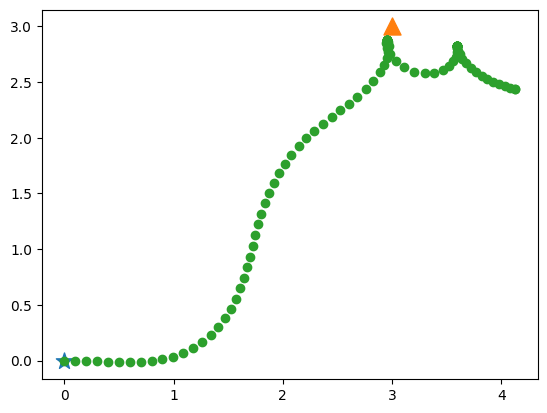

In [ ]:
#@title Iterative LQG
class IterativeLQG:
  def __init__(self,
               max_iter = 100,
               x0 = np.zeros(3),
               num_states = 3,
               num_actions = 2,
               motion_model = Unicycle(),
               K = 100,
               T = 10,
               ):
    #time discretization
    self.Q = np.eye(3)
    self.R = np.eye(2)
    self.K = K
    self.T = T
    self.num_states = num_states
    self.num_actions = num_actions
    self.dt = self.T / (self.K - 1)
    self.u = np.zeros((K-1, 2))
    self.max_iter = max_iter
    self.motion_model = motion_model
    self.eps_convergence = 1e-3
    self.lmbd_factor = 10
    self.lmbd_max = 1000

  def ilqg(self, x0, target):
    first_iter = True
    self.x0 = x0
    self.target = target
    u = self.u
    lmbd = 1.0

    for i in range(self.max_iter):
      if first_iter:
        x_traj, f_x, f_u, l, l_x, l_xx, l_u, l_uu, l_ux, A, B, cost = self.init_ilqg(x0, u)
        old_cost = np.copy(cost)
        first_iter = False
      V = l[-1].copy()
      V_x = l_x[-1].copy()
      V_xx = l_xx[-1].copy()
      k = np.zeros((self.K, self.num_actions))
      K = np.zeros((self.K, self.num_actions, self.num_states))

      for t in range(self.K-2, -1, -1):
        Q_x = l_x[t] + np.dot(f_x[t].T, V_x)
        Q_u = l_u[t] + np.dot(f_u[t].T, V_x)

        #might need to include second derivatives of motion model
        Q_xx = l_xx[t] + np.dot(f_x[t].T, np.dot(V_xx, f_x[t]))
        Q_ux = l_ux[t] + np.dot(f_u[t].T, np.dot(V_xx, f_x[t]))
        Q_uu = l_uu[t] + np.dot(f_u[t].T, np.dot(V_xx, f_u[t]))

        #levenberg-marquardt heuristic
        Q_uu_evals, Q_uu_evecs = np.linalg.eig(Q_uu)
        Q_uu_evals[Q_uu_evals < 0] = 0.0
        Q_uu_evals += lmbd
        Q_uu_inv = np.dot(Q_uu_evecs, np.dot(np.diag(1.0 / Q_uu_evals), Q_uu_evecs.T))

        k[t] = -np.dot(Q_uu_inv, Q_u)
        K[t] = -np.dot(Q_uu_inv, Q_ux)

        V_x = Q_x - np.dot(K[t].T, np.dot(Q_uu, k[t]))
        V_xx = Q_xx - np.dot(K[t].T, np.dot(Q_uu, K[t]))

      u_new = np.zeros((self.K, self.num_actions))
      x_new = self.x0.copy()
      for t in range(self.K - 1):
        u_new[t] = u[t] + k[t] + np.dot(K[t], x_new - x_traj[t])
        _, x_next = self.motion_model_step(x_new, u_new[t])

      x_new, cost_new = self.simulate(self.x0, u_new)

      #levenberg-marquardt heuristic
      if cost_new < cost:
        print(cost_new)
        lmbd /= self.lmbd_factor
        x_traj = np.copy(x_new)
        u = np.copy(u_new)
        old_cost = np.copy(cost)
        cost = np.copy(cost_new)
        first_iter = True

        if i > 0 and ((np.abs(old_cost - cost)/cost) < self.eps_convergence):
          print(f"Converged at iteration {i}")
          break
      else:
        lmbd *= self.lmbd_factor
        if lmbd > self.lmbd_max:
          print(f"Lambda > Lambda_max, at iteration {i}")
          break

    return x_traj, u, cost

  def init_ilqg(self, x0, u):
    x_traj, cost = self.simulate(x0, u)
    old_cost = np.copy(cost)
    f_x = np.zeros((self.K, self.num_states, self.num_states))
    f_u = np.zeros((self.K, self.num_states, self.num_actions))
    l = np.zeros((self.K, 1))
    l_x = np.zeros((self.K, self.num_states))
    l_xx = np.zeros((self.K, self.num_states, self.num_states))
    l_u = np.zeros((self.K, self.num_actions))
    l_uu = np.zeros((self.K, self.num_actions, self.num_actions))
    l_ux = np.zeros((self.K, self.num_actions, self.num_states))
    for t in range(self.K-1):
      A, B = self.finite_differences(x_traj[t], u[t])
      f_x[t] = np.eye(self.num_states) + A * self.dt
      f_u[t] = B * self.dt

      l[t], l_x[t], l_xx[t], l_u[t], l_uu[t], l_ux[t] = self.calculate_cost(x_traj[t], u[t])
      l[t] *= self.dt
      l_x[t] *= self.dt
      l_xx[t] *= self.dt
      l_u[t] *= self.dt
      l_uu[t] *= self.dt
      l_ux[t] *= self.dt

    l[-1], l_x[-1], l_xx[-1] = self.final_cost(x_traj[-1])

    return x_traj, f_x, f_u, l, l_x, l_xx, l_u, l_uu, l_ux, A, B, old_cost

  def finite_differences(self, x, u):
    eps = 1e-3

    A = np.zeros((self.num_states, self.num_states))
    for i in range(self.num_states):
      x_plus = x.copy()
      x_plus[i] += eps
      next_plus, _ = self.motion_model_step(x_plus, u)
      x_minus = x.copy()
      x_minus[i] -= eps
      next_minus, _ = self.motion_model_step(x_minus, u)
      A[:, i] = (next_plus - next_minus) / (2 * eps)

    B = np.zeros((self.num_states, self.num_actions))
    for i in range(self.num_actions):
      u_plus = u.copy()
      u_plus[i] += eps
      next_plus, _ = self.motion_model_step(x.copy(), u_plus)
      u_minus = u.copy()
      u_minus[i] -= eps
      next_minus, _ = self.motion_model_step(x.copy(), u_minus)
      B[:, i] = (next_plus - next_minus) / (2 * eps)

    return A, B

  def motion_model_step(self, x, u):
    x_next = self.motion_model.step(x, u, dt = self.dt)
    x_change = (x_next - x) / self.dt

    return x_change, x_next

  def calculate_cost(self, x, u):
    #x and u should be vectors
    x = x - self.target
    l = x.T @ self.Q @ x + u.T @ self.R @ u

    l_x = 2 * self.Q @ x
    l_xx = 2 * self.Q
    l_u = 2 * self.R @ u
    l_uu = 2 * self.R
    l_ux = np.zeros((self.num_actions, self.num_states))

    return l, l_x, l_xx, l_u, l_uu, l_ux

  def final_cost(self, x):
    l = np.sum((x - self.target)**2)
    l_x = 2 * (x - self.target)
    l_xx = 2 * np.eye(self.num_states)
    return l, l_x, l_xx

  def simulate(self, x0, u):
    xs = [x0]
    cost = 0.0
    for i in range(len(u)):
      xs.append(self.motion_model.step(xs[i], u[i], self.dt))
      l, *_ = self.calculate_cost(xs[i], u[i])
      cost += l * self.dt

    l_f, *_ = self.final_cost(xs[-1])
    cost += l_f

    return np.array(xs), cost


#simple example where the unicycle goes from [0, 0] to [3, 3]
ilqg = IterativeLQG()
#return x_traj, u, cost
x_traj, u, cost = ilqg.ilqg(x0 = np.array([0, 0, 0]), target = np.array([3, 3, np.pi/2]))

motion_model = Unicycle()
cur_state = np.array([0, 0, 0])
xs = [cur_state[:2]]
for control in u:
  next_state = motion_model.step(cur_state, control)
  xs.append(next_state[:2])
  cur_state = next_state

xs = np.array(xs)
plt.scatter(0, 0, s = 150, marker = '*')
plt.scatter(3, 3, s = 150, marker = '^')
plt.scatter(xs[:, 0], xs[:, 1])
#need to tune cost function so its more attuned to what we're doing!!

In [ ]:
#@title Tube MPC
class TubeMPC:
    def __init__(self):
      self.nominal = MPPIRaceTrack()
      self.z = np.zeros(3)
      self.ancillary = None
      pass

    def solve_ancillary(self):
      """The ancillary controller finds the control seq which minimizes the
      difference between the uncertain state and the nominal state"""

      pass

    def solve_nominal(self):
      rollouts, controls = self.mppi.get_action(self.z)

      return rollouts, controls

    def solve(self):
      #current state of uncertain system
      x = None
      #current state of nomial system
      z = None

      #solve the nominal system and get the states and controls
      rollouts, controls = self.solve_nominal()

      #solve ancillary problem and obtain control
      self.solve_ancillary()

      #apply control found from solving ancillary problem to the uncertain system
      #measure the successor state

      #simulate the next state of nominal system

      #repeat

In [ ]:
#@title Run Racetrack
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3,
) -> int:

    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    for t in range(num_timesteps):
      if t % 50 == 0:
        print("Time step", t)
      action = planner.get_action(obs)
      obs, _, terminated, _, _ = env.step(action)

      ax.plot(obs[0], obs[1], "bx")

      if terminated:
          success = True
          break

    num_timesteps_used = t

    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1


# seed = 0
seed = np.random.randint(0, 3000)
num_laps = 3
planner_class = MPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")